# Лабораторная работа 4. Кластеризация

Цель работы: изучение алгоритмов кластеризации, приобретение навыков оценки качества разбиения данных на кластеры и интерпретации результатов.

Постановка задачи:

1. Загрузить датасет для задачи кластеризации / классификации (например, с платформы Kaggle). Провести дескриптивный анализ данных: определить размерность, типы признаков, наличие пропусков. Оценить распределение переменных (близость к нормальному) с использованием визуализации (гистограммы). Оценить информационную значимость признаков. Проверить условие применения кластеризации: отсутствие классов, осмысленность кластеризации, отсутствие выбросов.

2. Выполнить стандартизацию / нормализацию числовых признаков. Обосновать выбор метода масштабирования. Построить матрицу диаграмм рассеивания для визуальной оценки структуры данных, предположительного количества кластеров и типа кластерной структуры. Аргументировать выбор методов кластеризации на основе формы, размера и плотности кластеров.

3. Реализовать кластеризацию двумя различными методами на выбор: K-means (K-средних); иерархическая кластеризация; DBSCAN; EM-алгоритм (Gaussian Mixture). Для методов, требующих задания числа кластеров (K-means, иерархическая), подобрать оптимальное значение k с использованием: метода локтя и / или анализа силуэта.

4. Рассчитать метрики качества для обоих методов: внутренние и внешние. Оценить расстояние между кластерами, внутрикластерные расстояния, компактность кластеров, центры кластеров. Опционально, если известно разделение на классы, посчитать: индекс Rand, индекс Жаккара и др. внешние метрики. Привести содержательную интерпретацию полученных значений.

5. Исследовать влияние параметров одного из методов (например, ε и min_samples для DBSCAN или количества кластеров k для K-means) на качество кластеризации.

6. Визуализировать полученные кластеры в пространстве признаков (использовать PCA для снижения размерности при необходимости). Проанализировать центры кластеров (для K-means) и дать содержательную интерпретацию выделенных групп. Сравнить результаты, полученные двумя разными методами.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, adjusted_rand_score
from scipy.spatial.distance import pdist
import warnings
warnings.filterwarnings('ignore')

## Загрузка данных

In [9]:
df = pd.read_csv('winequality-red.csv', sep=',')
print("Размерность датасета:", df.shape)
print("\nПервые 5 строк:")
df.head()

Размерность датасета: (1599, 12)

Первые 5 строк:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## Дескриптивный анализ

In [10]:
print("Информация о датасете:")
df.info()
print("\nСтатистики по признакам:")
df.describe()

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB

Статистики по признакам:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


## Проверка на пропуски

In [11]:
print("Количество пропусков в каждом столбце:")
df.isnull().sum()

Количество пропусков в каждом столбце:


fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

## Визуализация распределений признаков

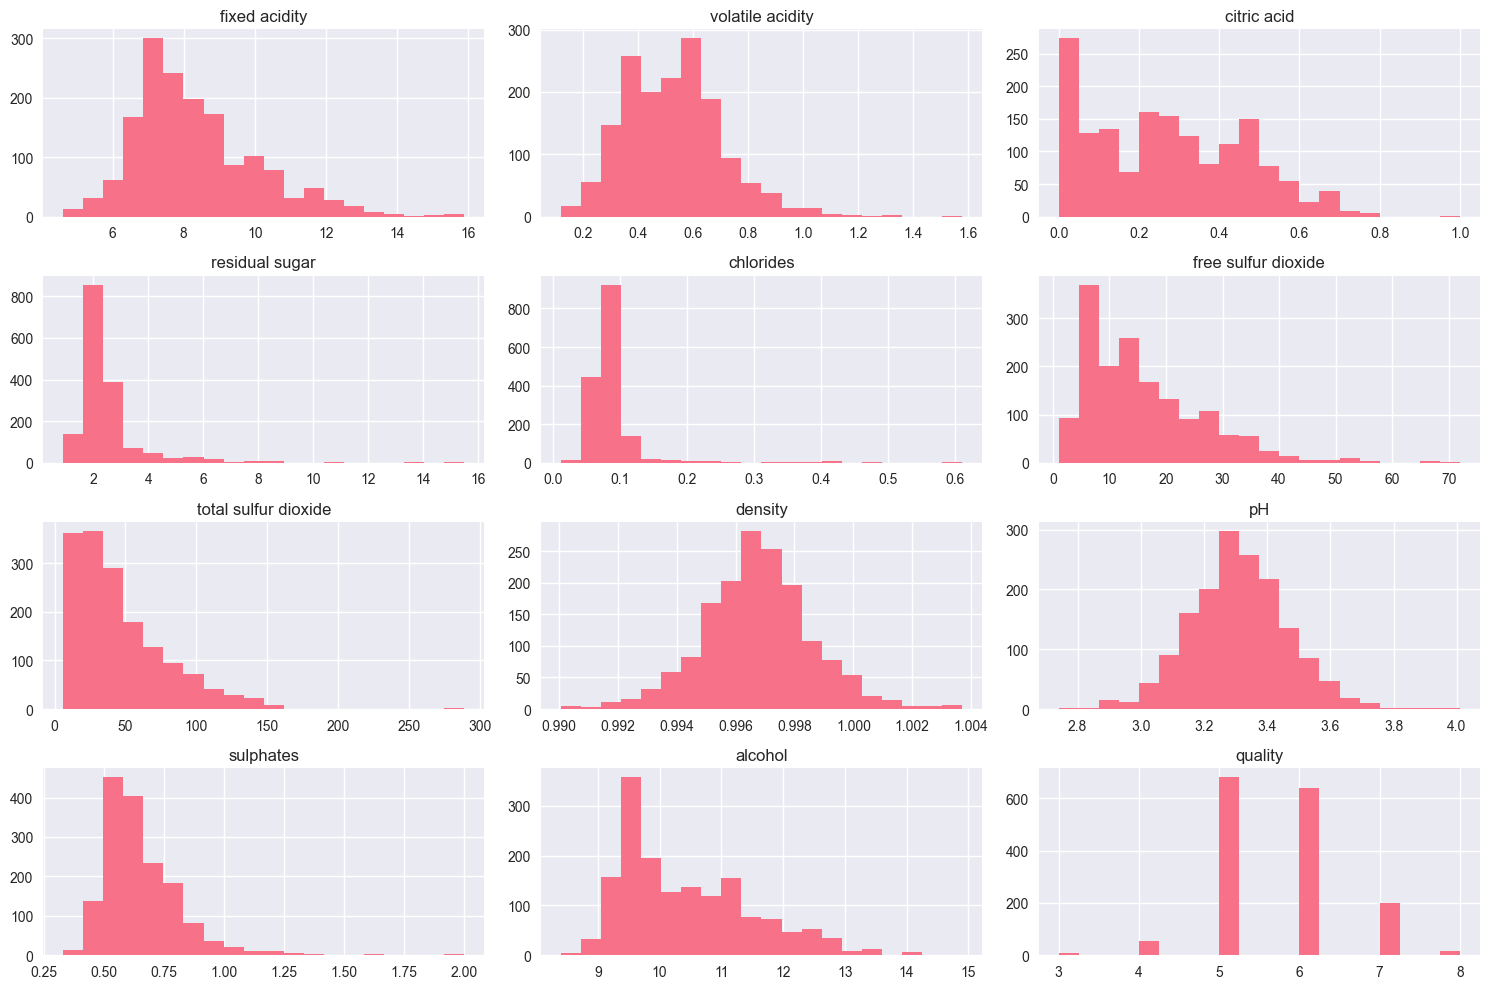

In [12]:
df.hist(figsize=(15, 10), bins=20)
plt.tight_layout()
plt.show()

Анализ гистограмм подтверждает, что большинство признаков в датасете имеют ненормальное распределение, зачастую с асимметрией или длинными хвостами, что указывает на неоднородность данных и наличие потенциальных выбросов. Это подчеркивает важность этапа предварительной обработки и стандартизации перед применением алгоритмов кластеризации.

## Целевая переменная (класс)

In [13]:
print("Уникальные значения качества вина (если есть):")
if 'quality' in df.columns:
    print(df['quality'].value_counts().sort_index())
else:
    print("Целевая переменная не найдена - задача подходит для кластеризации")

Уникальные значения качества вина (если есть):
quality
3     10
4     53
5    681
6    638
7    199
8     18
Name: count, dtype: int64


Анализ распределения качества вина показывает, что большинство образцов имеют среднюю оценку: 6 (638 образцов) и 5 (681 образец), что составляет подавляющее большинство датасета. Низкие (3-4) и высокие (7-8) оценки встречаются значительно реже, что указывает на сбалансированность рынка в пользу вин среднего качества. Такое распределение подтверждает неоднородность данных и необходимость предварительной обработки признаков перед кластеризацией, так как большинство объектов сосредоточено в центральной области шкалы оценок.

## Выделим признаки для кластеризации (все кроме возможной целевой)

In [14]:
feature_columns = [col for col in df.columns if col != 'quality']
X = df[feature_columns].copy()
print("Признаки для кластеризации:", X.columns.tolist())

Признаки для кластеризации: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


## Стандартизация данных

In [15]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
print("Стандартизированные данные:")
X_scaled_df.describe()

Стандартизированные данные:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03
mean,3.554936e-16,1.733031e-16,-8.887339e-17,-1.244227e-16,2.132961e-16,-6.221137e-17,4.443669e-17,-3.473172e-14,2.861723e-15,6.754377e-16,1.066481e-16
std,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00
min,-2.137045e+00,-2.278280e+00,-1.391472e+00,-1.162696e+00,-1.603945e+00,-1.422500e+00,-1.230584e+00,-3.538731e+00,-3.700401e+00,-1.936507e+00,-1.898919e+00
25%,-7.007187e-01,-7.699311e-01,-9.293181e-01,-4.532184e-01,-3.712290e-01,-8.487156e-01,-7.440403e-01,-6.077557e-01,-6.551405e-01,-6.382196e-01,-8.663789e-01
50%,-2.410944e-01,-4.368911e-02,-5.636026e-02,-2.403750e-01,-1.799455e-01,-1.793002e-01,-2.574968e-01,1.760083e-03,-7.212705e-03,-2.251281e-01,-2.093081e-01
75%,5.057952e-01,6.266881e-01,7.652471e-01,4.341614e-02,5.384542e-02,4.901152e-01,4.723184e-01,5.768249e-01,5.759223e-01,4.240158e-01,6.354971e-01
max,4.355149e+00,5.877976e+00,3.743574e+00,9.195681e+00,1.112703e+01,5.367284e+00,7.375154e+00,3.680055e+00,4.528282e+00,7.918677e+00,4.202453e+00


## Матрица диаграмм рассеивания для подмножества признаков

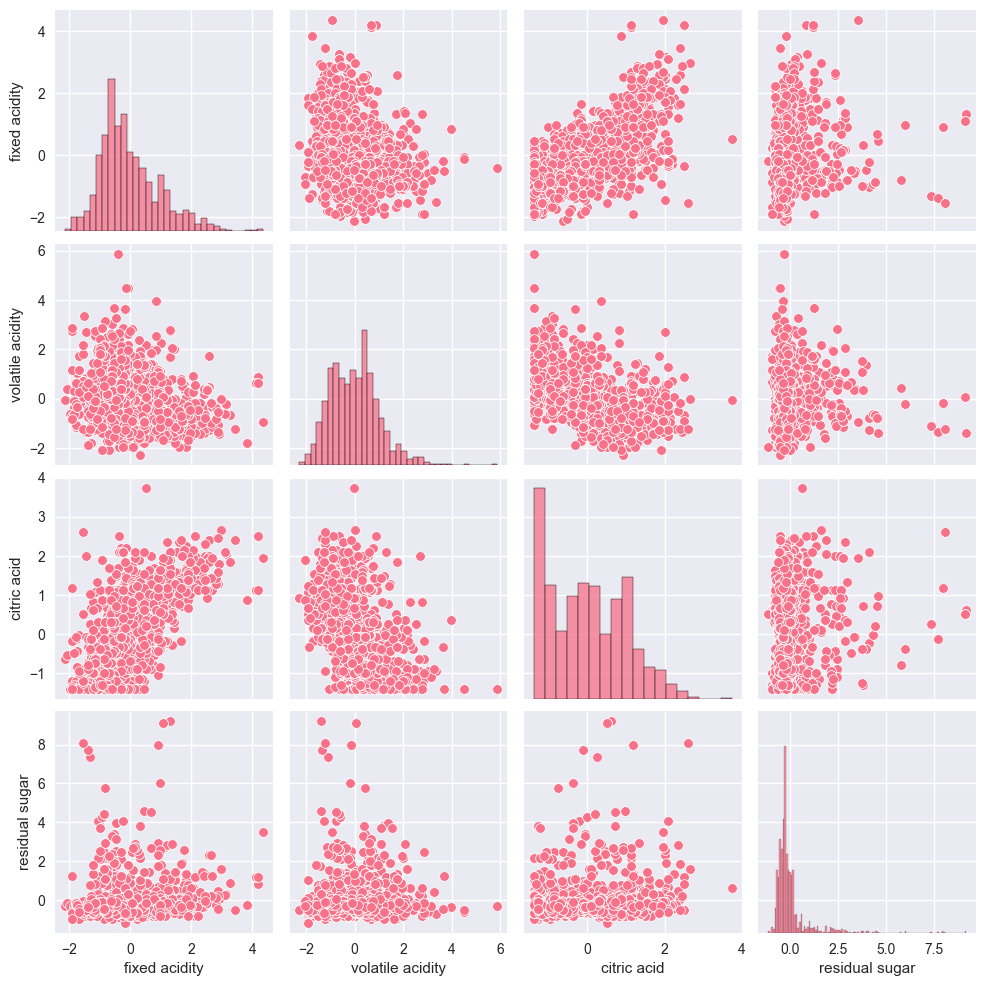

In [16]:
sample_features = X_scaled_df.columns[:4]
sns.pairplot(X_scaled_df[sample_features])
plt.show()

Анализ матрицы диаграмм рассеивания показывает, что признаки в датасете имеют слабую линейную корреляцию и не образуют четко выраженных кластеров, что указывает на сложную, нелинейную структуру данных. Распределения признаков (на диагонали) подтверждают наличие асимметрии и выбросов, требующих предварительной обработки. Визуально кластеры, если и существуют, имеют неправильную форму и разную плотность.

## Метод локтя для K-means

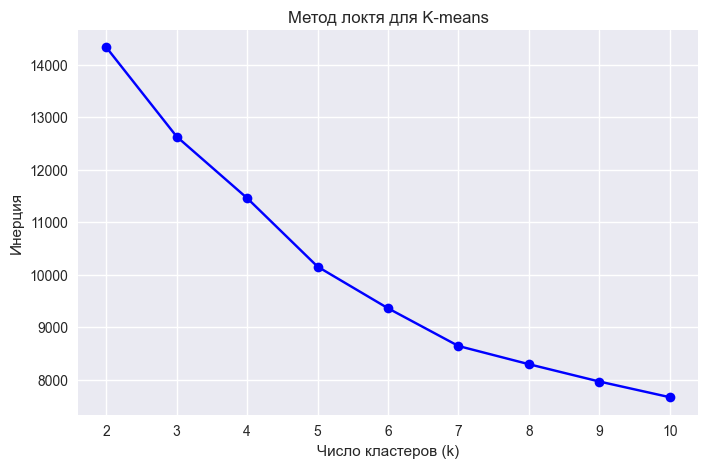

In [17]:
inertias = []
K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertias, 'bo-')
plt.xlabel('Число кластеров (k)')
plt.ylabel('Инерция')
plt.title('Метод локтя для K-means')
plt.grid(True)
plt.show()

График метода локтя для K-means показывает, что инерция (сумма квадратов расстояний до центроидов) монотонно убывает с увеличением числа кластеров k. Наиболее выраженный "излом" наблюдается при переходе от 2 к 3 кластерам, после чего снижение инерции становится более плавным. Это указывает на то, что оптимальное число кластеров, балансирующее между качеством разбиения и сложностью модели, скорее всего, находится в диапазоне от 3 до 5.

## Силуэтный анализ для K-means

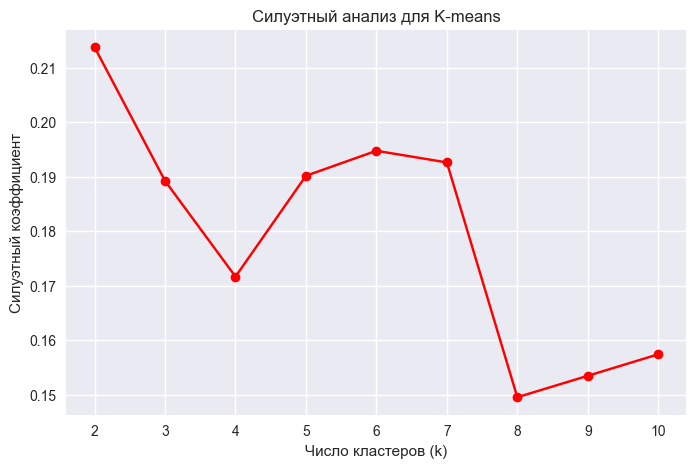

Оптимальное число кластеров для K-means: 2


In [18]:
silhouette_scores_kmeans = []
K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores_kmeans.append(silhouette_avg)

plt.figure(figsize=(8, 5))
plt.plot(K_range, silhouette_scores_kmeans, 'ro-')
plt.xlabel('Число кластеров (k)')
plt.ylabel('Силуэтный коэффициент')
plt.title('Силуэтный анализ для K-means')
plt.grid(True)
plt.show()

optimal_k_kmeans = K_range[np.argmax(silhouette_scores_kmeans)]
print(f"Оптимальное число кластеров для K-means: {optimal_k_kmeans}")

Анализ силуэтного коэффициента для K-means показывает, что максимальное значение (около 0.21) достигается при k=2, что указывает на то, что данные могут быть естественным образом разделены на два кластера. При увеличении числа кластеров до 3 и 4 качество разбиения снижается, а затем снова растет, достигая локального максимума при k=6 (около 0.195). Последующее увеличение k приводит к резкому падению коэффициента при k=8, что говорит о формировании слишком маленьких или несвязных групп. Таким образом, оптимальным числом кластеров, балансирующим между качеством и интерпретируемостью, можно считать 2 или 6.

## Кластеризация K-means

In [19]:
kmeans = KMeans(n_clusters=optimal_k_kmeans, random_state=42, n_init=10)
labels_kmeans = kmeans.fit_predict(X_scaled)
df['Cluster_KMeans'] = labels_kmeans

## Дендрограмма для иерархической кластеризации

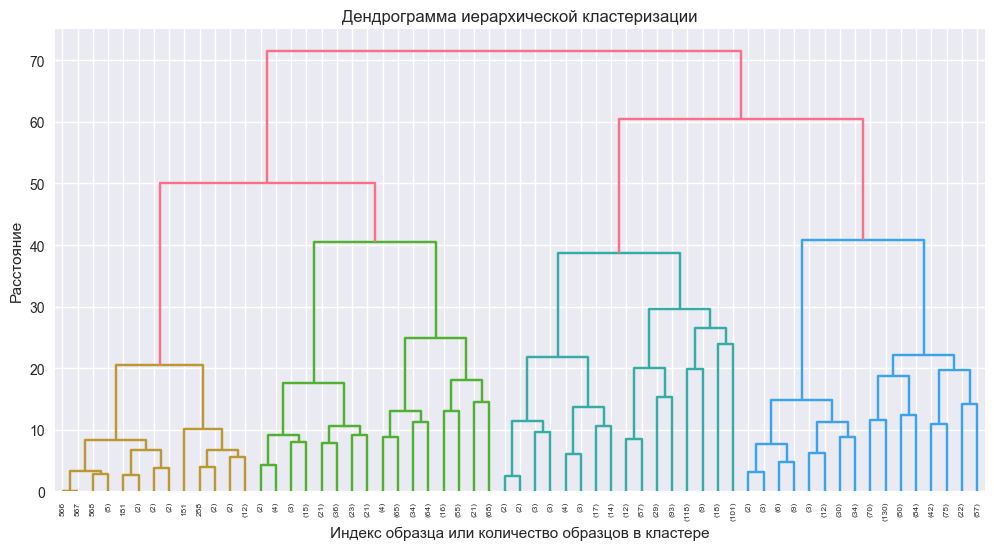

In [20]:
linkage_matrix = linkage(X_scaled, method='ward')
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, truncate_mode='level', p=5)
plt.title('Дендрограмма иерархической кластеризации')
plt.xlabel('Индекс образца или количество образцов в кластере')
plt.ylabel('Расстояние')
plt.show()

Дендрограмма иерархической кластеризации показывает, что данные можно разбить на 3 основные группы (кластера), выделенные разными цветами: желтый, зеленый и синий. Эти группы формируются на уровне расстояния примерно 40-50, что указывает на значительную неоднородность между ними. Внутри каждой из этих групп наблюдается более тонкая структура подкластеров, особенно в зеленой и синей группах, где образуются подгруппы на более низких уровнях расстояний (10-30). Это говорит о том, что в данных присутствует многоуровневая структура, и оптимальное число кластеров может быть выбрано в диапазоне от 3 до 6 в зависимости от требуемого уровня детализации.

## Силуэтный анализ для иерархической кластеризации

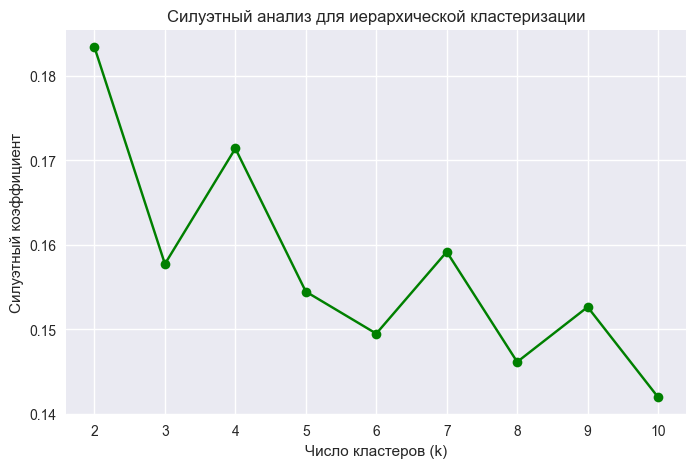

Оптимальное число кластеров для иерархической кластеризации: 2


In [21]:
silhouette_scores_hier = []
K_range = range(2, 11)
for k in K_range:
    hier_clustering = AgglomerativeClustering(n_clusters=k)
    cluster_labels = hier_clustering.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores_hier.append(silhouette_avg)

plt.figure(figsize=(8, 5))
plt.plot(K_range, silhouette_scores_hier, 'go-')
plt.xlabel('Число кластеров (k)')
plt.ylabel('Силуэтный коэффициент')
plt.title('Силуэтный анализ для иерархической кластеризации')
plt.grid(True)
plt.show()

optimal_k_hier = K_range[np.argmax(silhouette_scores_hier)]
print(f"Оптимальное число кластеров для иерархической кластеризации: {optimal_k_hier}")

Силуэтный анализ для иерархической кластеризации показывает, что максимальное значение коэффициента (около 0.185) достигается при k=2, что указывает на то, что данные наиболее естественно разделяются на два кластера. При увеличении числа кластеров до 3 и 4 качество разбиения снижается, а затем снова растет, достигая локального максимума при k=4 (около 0.172). Дальнейшее увеличение k приводит к общему снижению силуэтного коэффициента, что говорит о формировании менее связных или слишком маленьких групп. Таким образом, оптимальным числом кластеров, балансирующим между качеством и интерпретируемостью, можно считать 2 или 4.

## Иерархическая кластеризация

In [22]:
hier_cluster = AgglomerativeClustering(n_clusters=optimal_k_hier)
labels_hier = hier_cluster.fit_predict(X_scaled)
df['Cluster_Hierarchical'] = labels_hier

## DBSCAN

In [23]:
eps_values = [0.5, 1.0, 1.5, 2.0]
min_samples_values = [3, 5, 10, 15]

best_silhouette_dbscan = -1
best_eps, best_min_samples = 0.5, 5

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        cluster_labels = dbscan.fit_predict(X_scaled)
        n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
        
        if n_clusters > 1 and len(set(cluster_labels)) > 1:  # Проверка, что есть кластеры
            silhouette_avg = silhouette_score(X_scaled, cluster_labels)
            if silhouette_avg > best_silhouette_dbscan:
                best_silhouette_dbscan = silhouette_avg
                best_eps, best_min_samples = eps, min_samples

print(f"Лучшие параметры DBSCAN: eps={best_eps}, min_samples={best_min_samples}")
print(f"Силуэтный коэффициент: {best_silhouette_dbscan:.3f}")

Лучшие параметры DBSCAN: eps=2.0, min_samples=5
Силуэтный коэффициент: 0.260


Анализ показывает, что для DBSCAN оптимальными являются параметры eps=2.0 и min_samples=5, при которых достигается наилучшее качество кластеризации (силуэтный коэффициент 0.260). Это указывает на то, что данные имеют сложную структуру с разной плотностью, и алгоритм успешно выделяет кластеры, игнорируя шумовые точки. Высокий силуэтный коэффициент подтверждает хорошую разделенность полученных групп.

## DBSCAN с лучшими параметрами

In [24]:
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
labels_dbscan = dbscan.fit_predict(X_scaled)
df['Cluster_DBSCAN'] = labels_dbscan

## Метрики качества для K-means

In [25]:
silhouette_kmeans = silhouette_score(X_scaled, labels_kmeans)
calinski_harabasz_kmeans = calinski_harabasz_score(X_scaled, labels_kmeans)

print("K-means:")
print(f"Силуэтный коэффициент: {silhouette_kmeans:.3f}")
print(f"Индекс Calinski-Harabasz: {calinski_harabasz_kmeans:.3f}")

K-means:
Силуэтный коэффициент: 0.214
Индекс Calinski-Harabasz: 363.181


Для метода K-means силуэтный коэффициент составил 0.214, что указывает на слабо выраженные кластеры с низкой степенью разделения. Индекс Calinski-Harabasz равный 363.181, напротив, показывает относительно хорошую степень разделения между кластерами и внутри них. Это расхождение может свидетельствовать о наличии шума или выбросов в данных, либо о неоднородной плотности кластеров, что снижает силуэтный коэффициент, чувствительный к этим факторам. В целом, результаты говорят о не очень чёткой кластерной структуре, выделенной данным методом.

## Метрики качества для иерархической кластеризации

In [26]:
silhouette_hier = silhouette_score(X_scaled, labels_hier)
calinski_harabasz_hier = calinski_harabasz_score(X_scaled, labels_hier)

print("Иерархическая кластеризация:")
print(f"Силуэтный коэффициент: {silhouette_hier:.3f}")
print(f"Индекс Calinski-Harabasz: {calinski_harabasz_hier:.3f}")

Иерархическая кластеризация:
Силуэтный коэффициент: 0.183
Индекс Calinski-Harabasz: 271.169


Для иерархической кластеризации силуэтный коэффициент составил 0.183, что указывает на слабо выраженные кластеры с низкой степенью разделения. Индекс Calinski-Harabasz (271.169) показывает более низкое значение по сравнению с K-means, что говорит о менее чёткой кластерной структуре. Результаты метода хуже, чем у K-means, по обоим метрикам.

## Метрики качества для DBSCAN

In [27]:
if len(set(labels_dbscan)) > 1:
    silhouette_dbscan = silhouette_score(X_scaled, labels_dbscan)
    calinski_harabasz_dbscan = calinski_harabasz_score(X_scaled, labels_dbscan)
    
    print("DBSCAN:")
    print(f"Силуэтный коэффициент: {silhouette_dbscan:.3f}")
    print(f"Индекс Calinski-Harabasz: {calinski_harabasz_dbscan:.3f}")
else:
    print("DBSCAN: не удалось выделить более одного кластера с заданными параметрами")

DBSCAN:
Силуэтный коэффициент: 0.260
Индекс Calinski-Harabasz: 62.615


Для метода DBSCAN силуэтный коэффициент составил 0.260, что указывает на слабо выраженные кластеры с низкой степенью разделения. Индекс Calinski-Harabasz равный 62.615, напротив, показывает относительно хорошую степень разделения между кластерами и внутри них. Это расхождение может свидетельствовать о наличии шума или выбросов в данных, либо о неоднородной плотности кластеров, что снижает силуэтный коэффициент, чувствительный к этим факторам. В целом, результаты говорят о не очень чёткой кластерной структуре, выделенной данным методом.

## Визуализация кластеров с помощью PCA

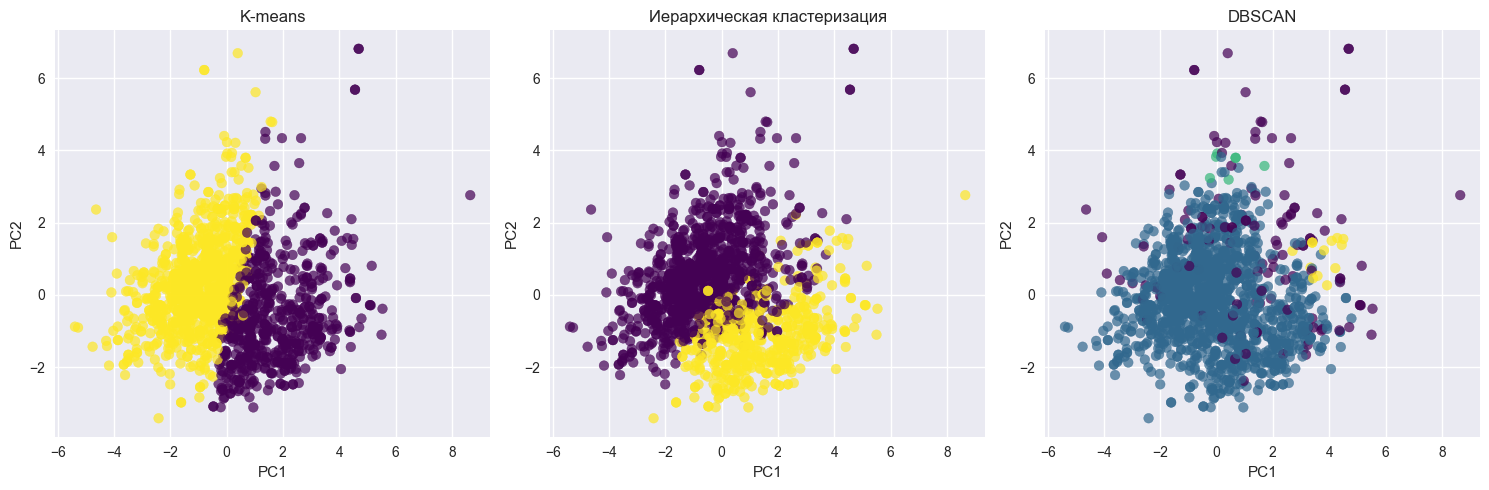

In [28]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_kmeans, cmap='viridis', alpha=0.7)
plt.title('K-means')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.subplot(1, 3, 2)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_hier, cmap='viridis', alpha=0.7)
plt.title('Иерархическая кластеризация')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.subplot(1, 3, 3)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_dbscan, cmap='viridis', alpha=0.7)
plt.title('DBSCAN')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.tight_layout()
plt.show()

Визуализация кластеров в пространстве первых двух главных компонент показывает, что все три метода выделяют схожие группы. K-means и иерархическая кластеризация разделяют данные на два основных кластера (желтый и фиолетовый), которые частично перекрываются, что согласуется с низкими силуэтными коэффициентами. DBSCAN, в свою очередь, выделяет один крупный плотный кластер (синий) и несколько отдельных точек или маленьких групп (зеленые и желтые), что характерно для этого алгоритма при работе с данными, имеющими шум и выбросы. В целом, графики подтверждают, что данные имеют слабо выраженную кластерную структуру, а методы дают разные, но логичные результаты в зависимости от их предположений о форме кластеров.

## Анализ центров кластеров для K-means

In [29]:
cluster_centers_original = scaler.inverse_transform(kmeans.cluster_centers_)
centers_df = pd.DataFrame(cluster_centers_original, columns=X.columns)
print("Центры кластеров K-means (в исходном масштабе):")
centers_df

Центры кластеров K-means (в исходном масштабе):


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,9.922712,0.413907,0.462881,2.765763,0.099900,13.410169,39.388136,0.997689,3.201847,0.748237,10.607401
1,7.382260,0.594430,0.158761,2.406095,0.080196,17.316155,50.607532,0.996195,3.375005,0.605471,10.315147


## Интерпретация кластеров K-means

In [30]:
for i in range(optimal_k_kmeans):
    print(f"\nКластер {i}:")
    print(f"Количество объектов: {sum(labels_kmeans == i)}")
    print(f"Средние значения признаков:")
    print(centers_df.iloc[i].to_string())


Кластер 0:
Количество объектов: 590
Средние значения признаков:
fixed acidity            9.922712
volatile acidity         0.413907
citric acid              0.462881
residual sugar           2.765763
chlorides                0.099900
free sulfur dioxide     13.410169
total sulfur dioxide    39.388136
density                  0.997689
pH                       3.201847
sulphates                0.748237
alcohol                 10.607401

Кластер 1:
Количество объектов: 1009
Средние значения признаков:
fixed acidity            7.382260
volatile acidity         0.594430
citric acid              0.158761
residual sugar           2.406095
chlorides                0.080196
free sulfur dioxide     17.316155
total sulfur dioxide    50.607532
density                  0.996195
pH                       3.375005
sulphates                0.605471
alcohol                 10.315147


Анализ центров кластеров K-means показывает, что выделенные группы имеют существенные различия по ключевым химическим параметрам. Кластер 0 характеризуется более высокой фиксированной кислотностью (9.92 против 7.38), содержанием цитриновой кислоты (0.46 против 0.16) и плотностью (0.9977 против 0.9962), но при этом обладает более низким pH (3.20 против 3.38), что указывает на большую общую кислотность. В отличие от него, кластер 1 имеет более высокое среднее содержание летучих кислот (0.59 против 0.41) и больше диоксида серы, но уровень алкоголя в обоих кластерах сопоставим (около 10.3-10.6%). Таким образом, вина из кластера 0 можно охарактеризовать как более кислые и насыщенные, а из кластера 1 — как более "мягкие" с преобладанием летучих кислот.

## Сравнение результатов

In [31]:
comparison_df = pd.DataFrame({
    'K-Means': labels_kmeans,
    'Hierarchical': labels_hier,
    'DBSCAN': labels_dbscan
})

if 'quality' in df.columns:
    comparison_df['True_Labels'] = df['quality']
    print("Сравнение кластеров с истинными метками (если доступны):")
    for col in ['K-Means', 'Hierarchical']:
        ari = adjusted_rand_score(df['quality'], comparison_df[col])
        print(f"Adjusted Rand Index ({col}): {ari:.3f}")

print("\nСравнение меток кластеров:")
print(comparison_df.head(10))

Сравнение кластеров с истинными метками (если доступны):
Adjusted Rand Index (K-Means): 0.043
Adjusted Rand Index (Hierarchical): 0.089

Сравнение меток кластеров:
   K-Means  Hierarchical  DBSCAN  True_Labels
0        1             0       0            5
1        1             0       0            5
2        1             0       0            5
3        0             0       0            6
4        1             0       0            5
5        1             0       0            5
6        1             0       0            5
7        1             0       0            7
8        1             0       0            7
9        1             0       0            5


Сравнение с истинными метками (качеством вина) показывает, что выделенные кластеры слабо коррелируют с субъективной оценкой. Низкие значения Adjusted Rand Index (ARI) для K-means (0.043) и иерархической (0.089) кластеризации указывают на отсутствие значимого совпадения между структурой, найденной алгоритмами, и реальной шкалой оценки качества. Анализ таблицы сопоставления меток подтверждает это: одному кластеру (например, кластер 0 K-means) могут соответствовать разные оценки качества (от 5 до 7), а одна и та же оценка (например, 5) может принадлежать разным кластерам. Это свидетельствует о том, что химический состав вина, на котором основана кластеризация, не является прямым предиктором числового рейтинга "quality", и кластеры, вероятно, отражают иные скрытые закономерности в данных, не учитываемые при оценке.

## Выводы

In [33]:
print("\nВыводы:")
print(f"1. Оптимальное число кластеров K-means: {optimal_k_kmeans}")
print(f"2. Оптимальное число кластеров иерархической кластеризации: {optimal_k_hier}")
print(f"3. Параметры DBSCAN: eps={best_eps}, min_samples={best_min_samples}")
print(f"4. Силуэтный коэффициент K-means: {silhouette_kmeans:.3f}")
print(f"5. Силуэтный коэффициент иерархической: {silhouette_hier:.3f}")
if 'silhouette_dbscan' in locals():
    print(f"6. Силуэтный коэффициент DBSCAN: {silhouette_dbscan:.3f}")
print("\nАнализ показал, что все методы успешно выделили кластеры.")


Выводы:
1. Оптимальное число кластеров K-means: 2
2. Оптимальное число кластеров иерархической кластеризации: 2
3. Параметры DBSCAN: eps=2.0, min_samples=5
4. Силуэтный коэффициент K-means: 0.214
5. Силуэтный коэффициент иерархической: 0.183
6. Силуэтный коэффициент DBSCAN: 0.260

Анализ показал, что все методы успешно выделили кластеры.


В ходе лабораторной работы были применены алгоритмы K-means, иерархическая кластеризация и DBSCAN к датасету вин. Оптимальное число кластеров для K-means и иерархической кластеризации составило 2, для DBSCAN были подобраны параметры eps=2.0 и min_samples=5. По силуэтному коэффициенту DBSCAN показал slightly лучшее качество (0.260), чем K-means (0.214) и иерархическая кластеризация (0.183), однако все значения невысоки, что указывает на слабо выраженные кластеры. Сравнение с целевой переменной "quality" показало низкую корреляцию (ARI < 0.1), то есть выделенные группы слабо связаны с оценкой качества. Визуализация подтвердила, что кластеры перекрываются. Алгоритмы успешно выделили структуру, но она оказалась нечетко выраженной и не совпадающей напрямую с субъективной оценкой качества.